In [1]:
from pyprojroot import here
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import re
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr


In [2]:
PROJECT_ROOT = here()
DATA_DIR = os.path.join(PROJECT_ROOT, "src", "tauso", "off_target", "Roni", "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "src", "tauso", "off_target", "Roni", "outputs")

ASO_DATA_DIR = os.path.join(PROJECT_ROOT, "notebooks", "data")
aso_data_path = os.path.join(ASO_DATA_DIR, "data_asoptimizer_updated.csv")
aso_df = pd.read_csv(aso_data_path)

/tmp/ipykernel_303141/2960252089.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  aso_df = pd.read_csv(aso_data_path)


In [3]:
aso_df = aso_df[["index", "Inhibition(%)"]].dropna()

pattern = os.path.join(OUTPUT_DIR, "off_target.*.csv")
files = glob.glob(pattern)

file_info = []

regex = re.compile(
    r"off_target\.(?P<method>[^.]+)\.(?P<scope>specific|general)\.top(?P<top>\d+)\.cutoff(?P<cutoff>\d+)\.csv"
)

for f in files:
    name = os.path.basename(f)
    m = regex.match(name)
    if m:
        info = m.groupdict()
        info["file"] = f
        info["colname"] = name.replace(".csv", "")
        info["top"] = int(info["top"])
        info["cutoff"] = int(info["cutoff"])
        file_info.append(info)

file_info = pd.DataFrame(file_info)
file_info.head()

,method,scope,top,cutoff,file,colname
0,ARTM_log,general,75,1300,/home/roniz/PycharmProjects/TAUSO/src/tauso/of...,off_target.ARTM_log.general.top75.cutoff1300
1,ARTM_log,specific,100,1200,/home/roniz/PycharmProjects/TAUSO/src/tauso/of...,off_target.ARTM_log.specific.top100.cutoff1200
2,ARTM_log,general,125,1300,/home/roniz/PycharmProjects/TAUSO/src/tauso/of...,off_target.ARTM_log.general.top125.cutoff1300
3,ARTM_log,specific,75,1100,/home/roniz/PycharmProjects/TAUSO/src/tauso/of...,off_target.ARTM_log.specific.top75.cutoff1100
4,ARTM_log,specific,75,1200,/home/roniz/PycharmProjects/TAUSO/src/tauso/of...,off_target.ARTM_log.specific.top75.cutoff1200


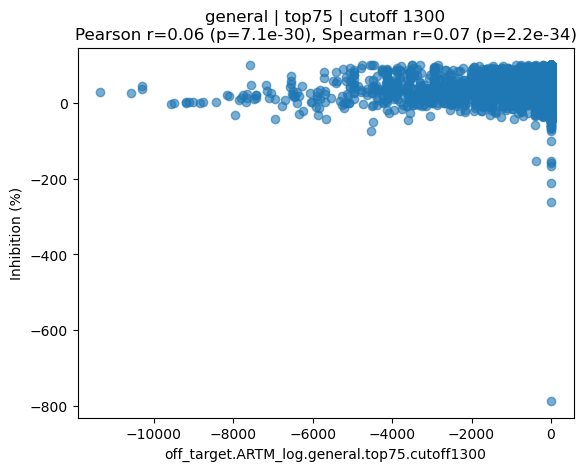

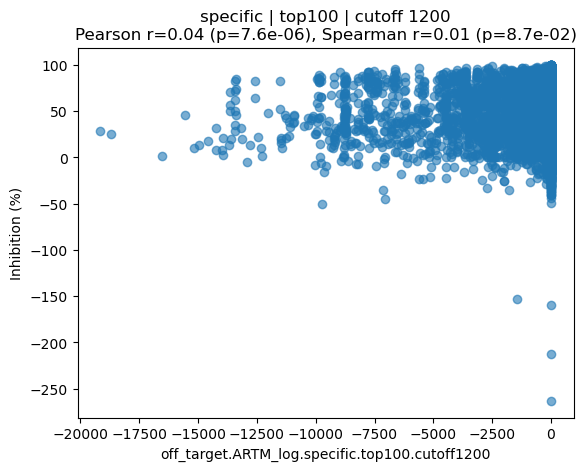

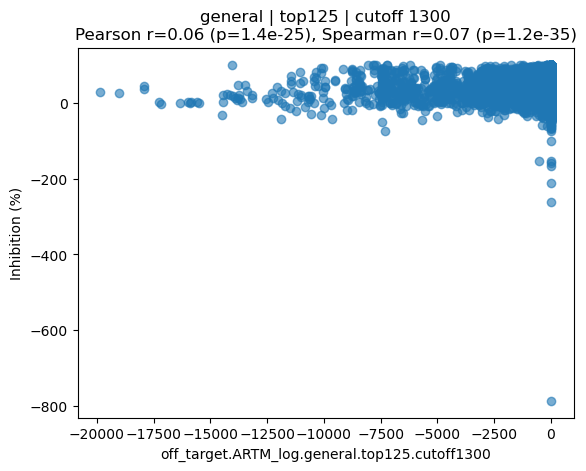

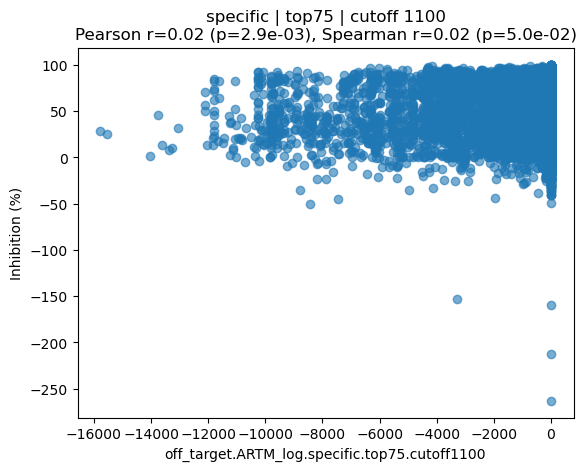

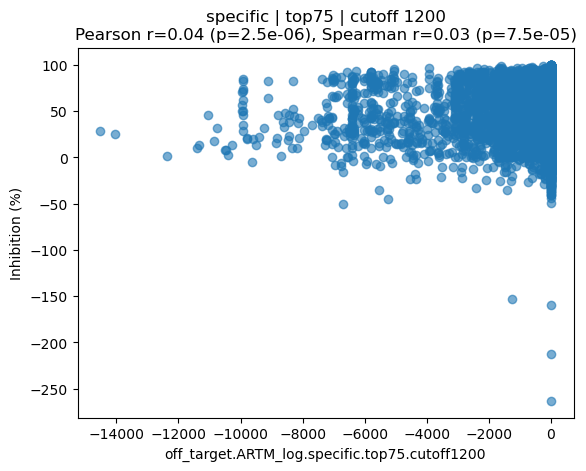

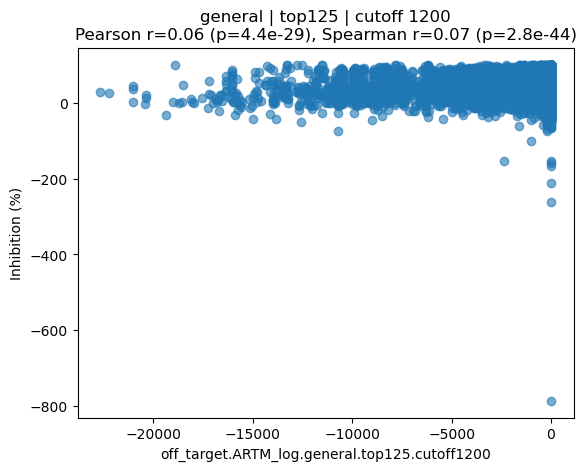

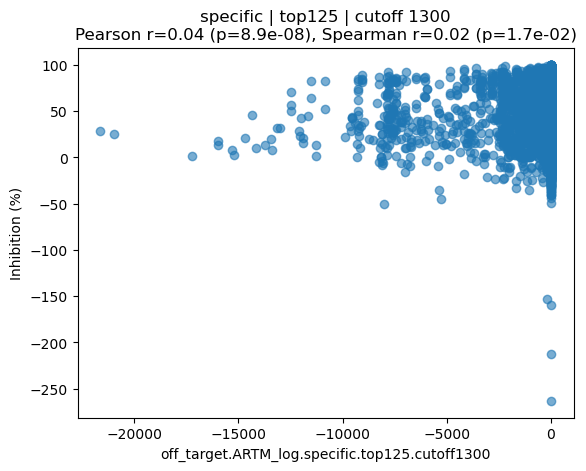

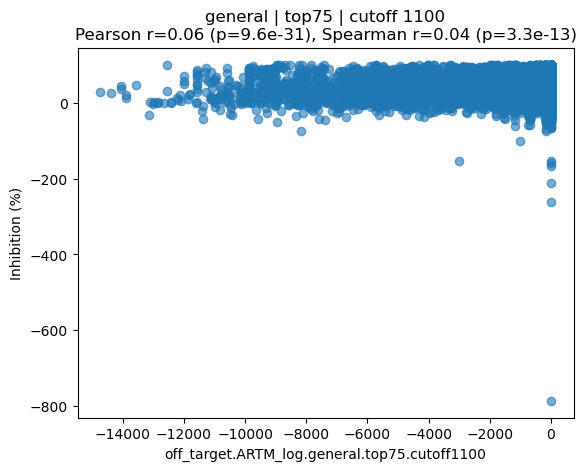

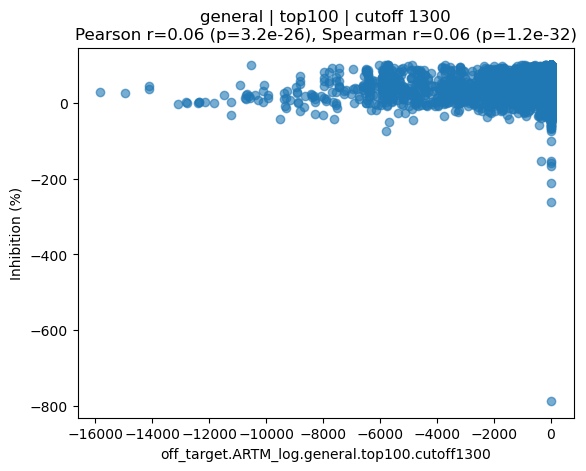

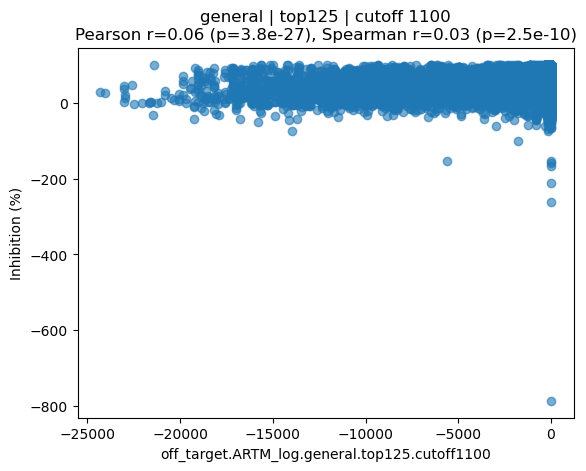

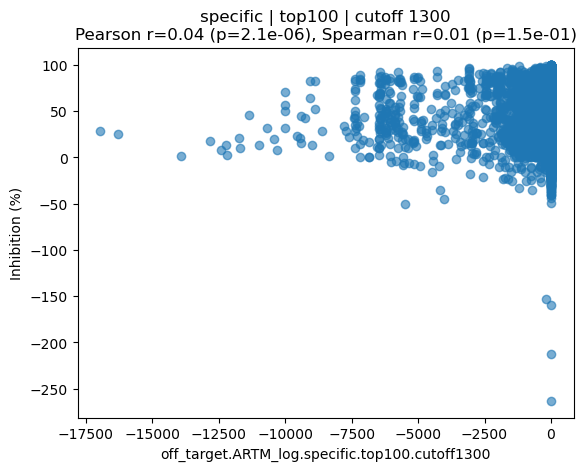

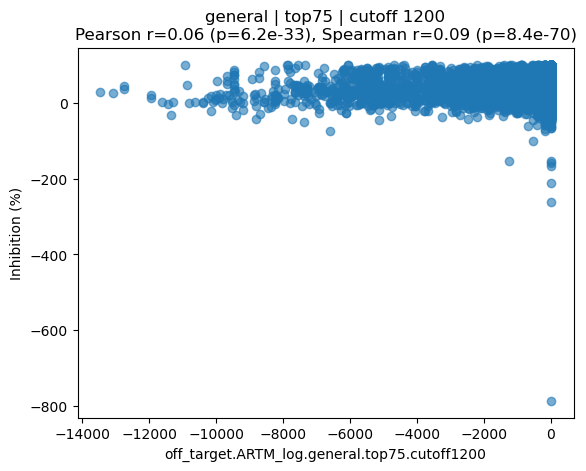

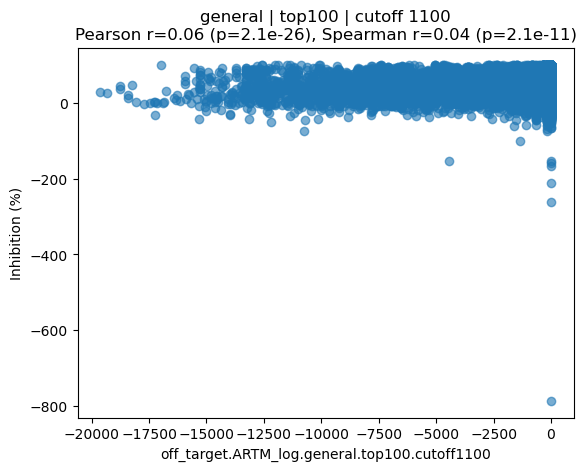

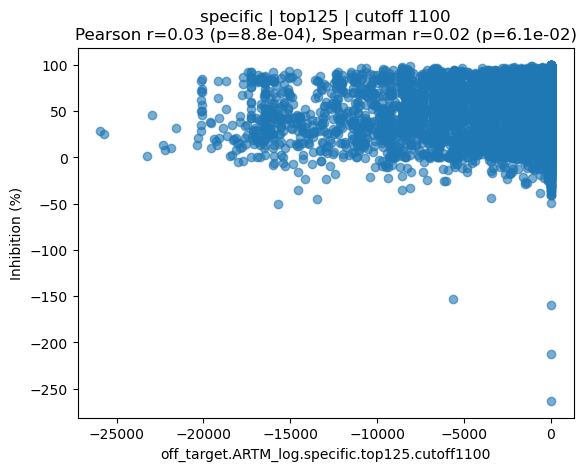

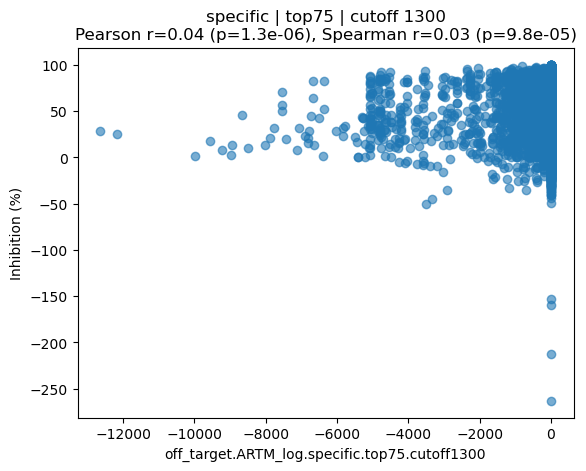

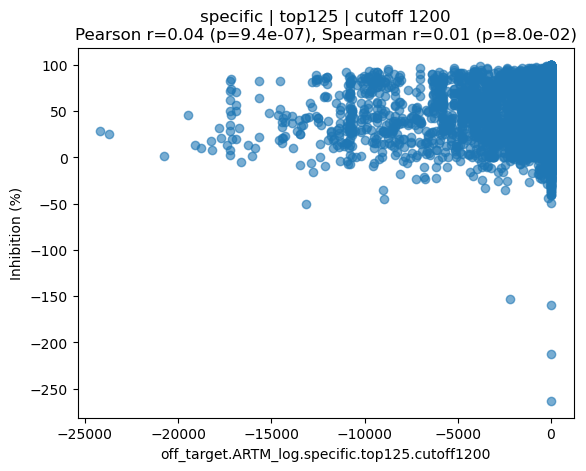

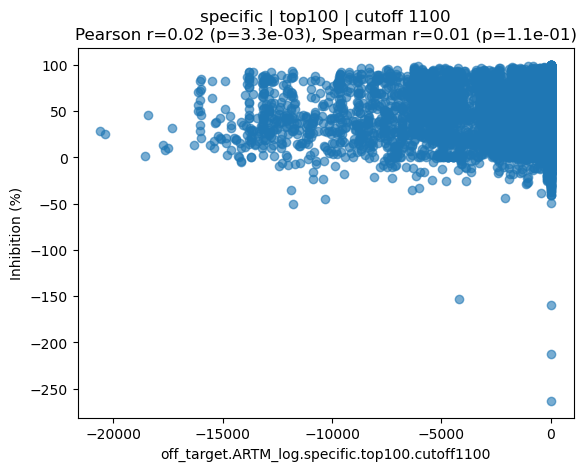

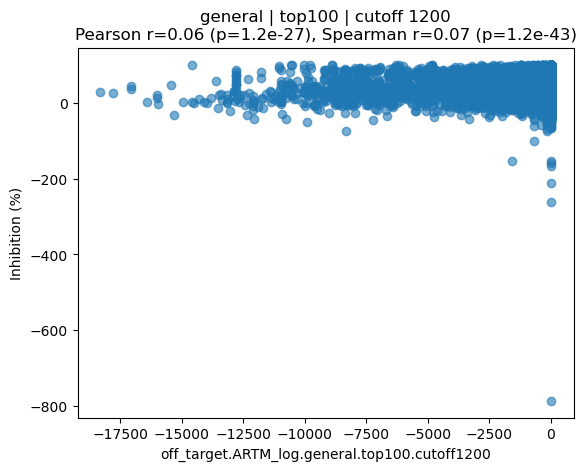

In [4]:
results = []

for _, row in file_info.iterrows():
    df = pd.read_csv(row["file"])

    df = df[["index", row["colname"]]].dropna()

    merged = aso_df.merge(df, on="index", how="inner")

    x = merged[row["colname"]]
    y = merged["Inhibition(%)"]

    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)

    results.append({
        "method": row["method"],
        "scope": row["scope"],
        "top": row["top"],
        "cutoff": row["cutoff"],
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_r": spearman_r,
        "spearman_p": spearman_p
    })

    # ---- scatter plot ----
    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.xlabel(row["colname"])
    plt.ylabel("Inhibition (%)")
    plt.title(
        f"{row['scope']} | top{row['top']} | cutoff {row['cutoff']}\n"
        f"Pearson r={pearson_r:.2f} (p={pearson_p:.1e}), "
        f"Spearman r={spearman_r:.2f} (p={spearman_p:.1e})"
    )
    plt.show()

In [5]:
results_df = pd.DataFrame(results)
results_df.sort_values(["scope", "cutoff", "top"]).head()

,method,scope,top,cutoff,pearson_r,pearson_p,spearman_r,spearman_p
7,ARTM_log,general,75,1100,0.061770,9.556472e-31,0.039050,3.253581e-13
12,ARTM_log,general,100,1100,0.056975,2.127223e-26,0.035929,2.069867e-11
9,ARTM_log,general,125,1100,0.057833,3.762679e-27,0.033929,2.488544e-10
11,ARTM_log,general,75,1200,0.064049,6.179081e-33,0.094510,8.412886e-70
17,ARTM_log,general,100,1200,0.058378,1.235513e-27,0.074198,1.218897e-43


In [8]:
def summary_plot(scope, corr_type="pearson_r"):
    df = results_df[results_df["scope"] == scope]

    plt.figure(figsize=(7, 5))

    for top in sorted(df["top"].unique()):
        sub = df[df["top"] == top]
        plt.scatter(
            sub["cutoff"],
            sub[corr_type],
            label=f"top{top}"
        )

    plt.xlabel("Cutoff")
    plt.ylabel(corr_type)
    plt.title(f"{scope.capitalize()} – {corr_type}")
    plt.legend(title="Top N")
    plt.show()

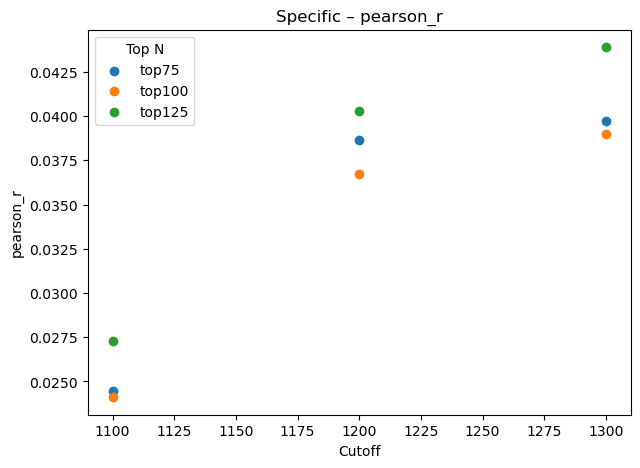

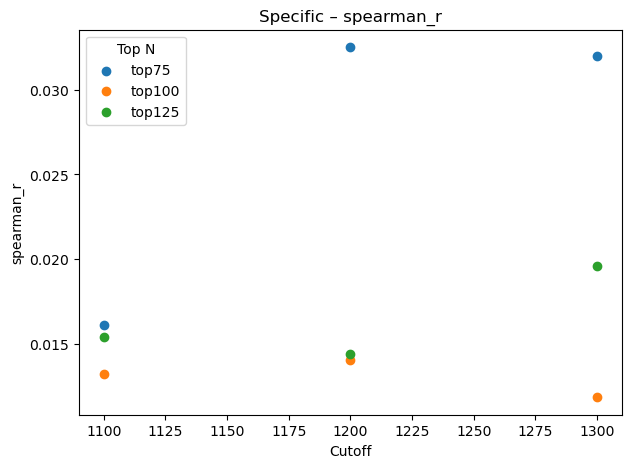

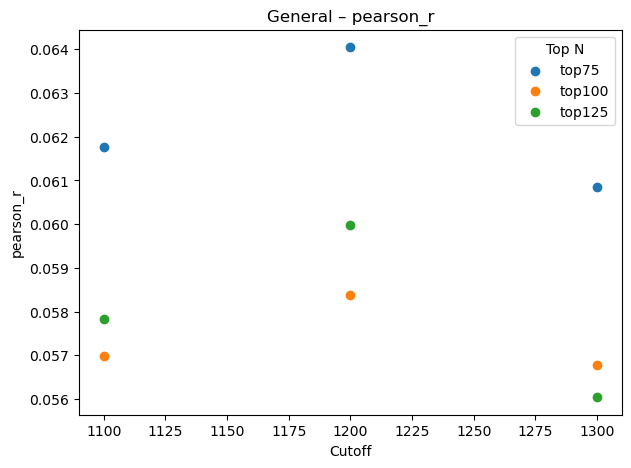

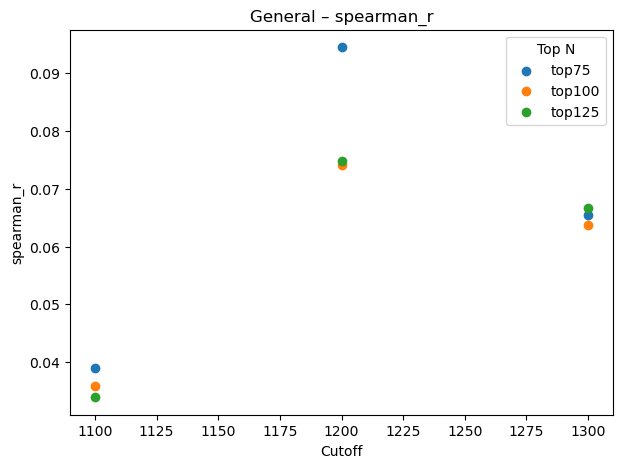

In [9]:
summary_plot("specific", "pearson_r")
summary_plot("specific", "spearman_r")

summary_plot("general", "pearson_r")
summary_plot("general", "spearman_r")